# Hierarchical Bayesian Modeling of CD8+ T-cell Exhaustion Dynamics in Cancer Using scRNA-seq Data and Markov Chain Monte Carlo

# Part 2: Single-Cell Gene Expression Probability Distribution

## Getting Started

#### Importing Libraries

In [19]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import gzip
import shutil
import requests
import re
from io import StringIO
import statsmodels.api as sm
from scipy.stats import nbinom
from scipy.stats import poisson
from scipy.optimize import minimize
from scipy.special import factorial
from scipy.stats import beta

#### Dataset

In [2]:
# loading data
file_path = './dataset/cd8_adata.h5ad'
cd8_adata = sc.read_h5ad(file_path)

In [5]:
# Check the structure of AnnData object
print(cd8_adata)

AnnData object with n_obs × n_vars = 6557 × 55737
    obs: 'Sample name', 'source name', 'organism', 'characteristics: patinet ID (Pre=baseline; Post= on treatment)', 'characteristics: response', 'characteristics: therapy', 'molecule', 'description', 'processed data file ', 'raw file', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_counts', 'n_genes'
    var: 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'


## Exploration of Gene Expression

In [20]:
# Progenitor exhausted genes
progenitor_ex_genes = ["TCF7", "CXCR5", "SLAMF6", "IL7R", "LEF1", "SELL", "STAT4", "FOXP1"]
# Terminal exhausted genes
terminal_ex_genes = ["PDCD1", "TOX", "HAVCR2", "CD38", "LAG3", "ENTPD1", "BATF", "LGALS9"]

In [8]:
# Extract raw PDCD1 counts from the dataset
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten()

# Ensure the counts are integers
raw_counts = np.round(raw_counts).astype(int)

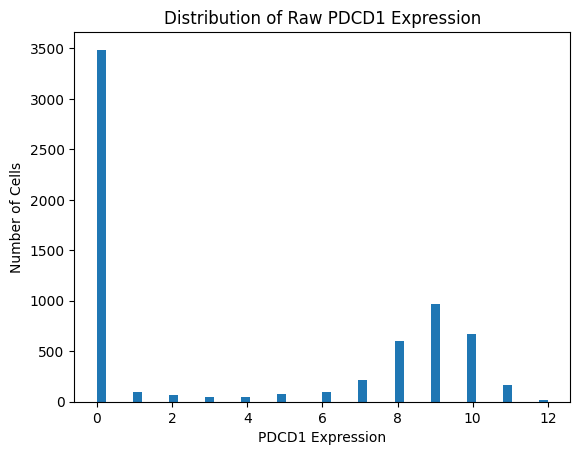

In [9]:
# Plot the distribution of PDCD1 expression values
plt.hist(raw_counts, bins=50)
plt.xlabel('PDCD1 Expression')
plt.ylabel('Number of Cells')
plt.title('Distribution of Raw PDCD1 Expression')
plt.show()

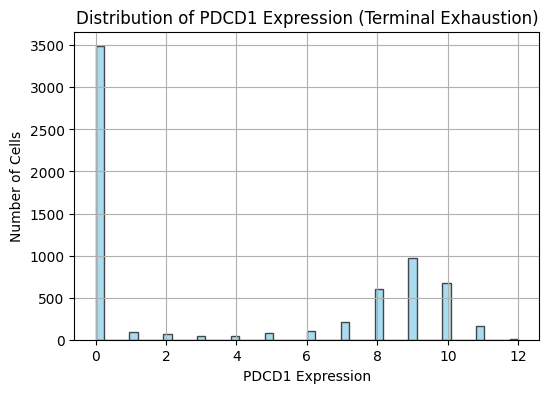

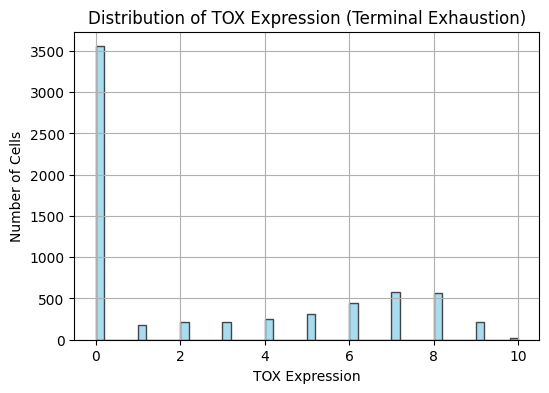

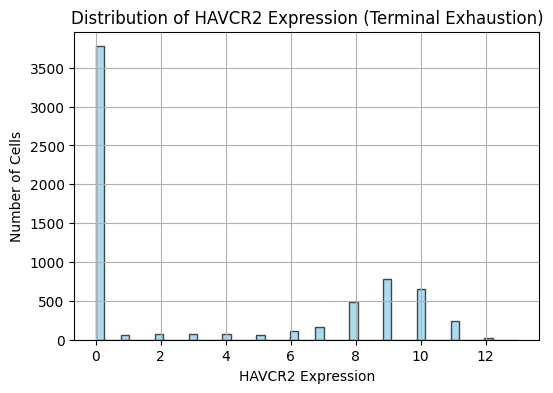

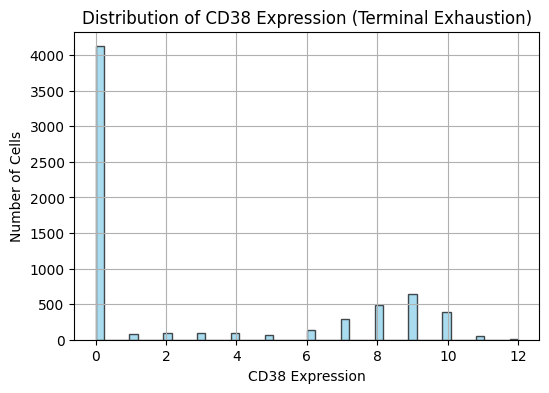

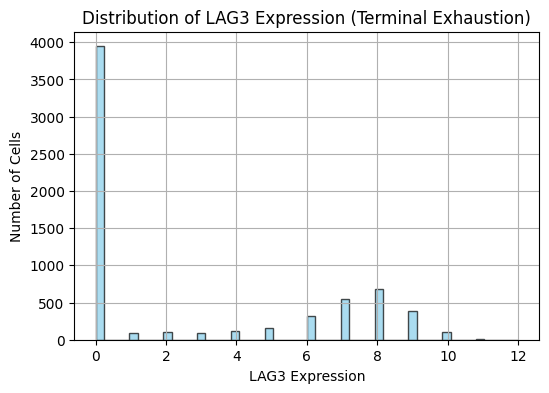

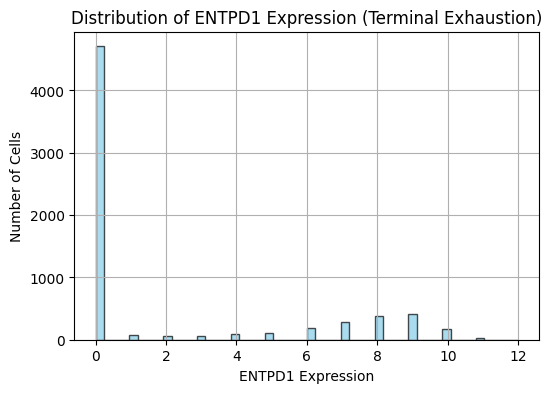

In [ ]:
# Function to plot the distribution of gene expression
def plot_gene_expression(adata, gene_list, group_name):
    for gene in gene_list:
        if gene in adata.var_names:  # Check if the gene exists in the dataset
            expression_values = adata[:, gene].X.flatten()
            expression_values = np.round(expression_values).astype(int)
            plt.figure(figsize=(6, 4))
            plt.hist(expression_values, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
            plt.xlabel(f'{gene} Expression')
            plt.ylabel('Number of Cells')
            plt.title(f'Distribution of {gene} Expression ({group_name})')
            plt.grid(True)
            plt.show()
        else:
            print(f"Gene {gene} not found in the dataset.")

# Plot distributions for terminal exhaustion genes
plot_gene_expression(cd8_adata, terminal_ex_genes, "Terminal Exhaustion")

# Plot distributions for progenitor exhaustion genes
plot_gene_expression(cd8_adata, progenitor_ex_genes, "Progenitor Exhaustion")

# Modeling Single-Cell Gene Expression
The following sections will explore several candidate models:
- Zero Inflated Poisson (**ZIP**) Model
- Zero Inflated Poisson Mixture (**ZIPM**) Model
- Zero Inflated Negative Binomial Mixture (**ZINBM**) Model
- Zero Inflated Generalized Poisson (**ZIGP**) Model
- Zero Inflated Generalized Poisson Mixture (**ZIGPM**) Model

## Zero-Inflated Poisson Model

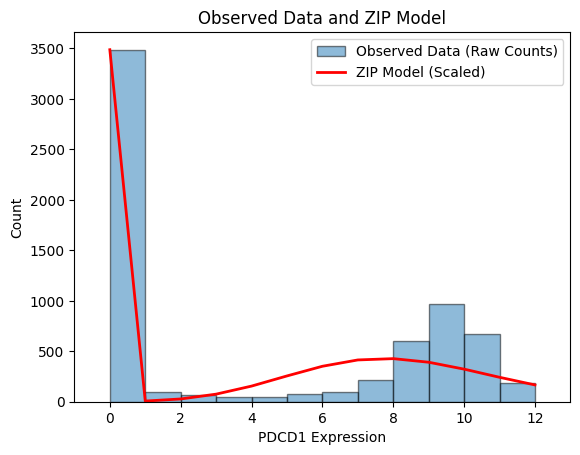

In [10]:
# Observed data
raw_counts = np.round(cd8_adata[:, 'PDCD1'].X.flatten()).astype(int)

# Estimate ZIP parameters
pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
lambda_poisson = raw_counts[raw_counts > 0].mean()  # Mean of non-zero counts

# Define the ZIP PMF
def zip_pmf(x, pi_zero, lambda_poisson):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.exp(-lambda_poisson)
    else:
        return (1 - pi_zero) * poisson.pmf(x, lambda_poisson)

# Generate the ZIP curve
x_values = np.arange(0, raw_counts.max() + 1)
zip_probs = [zip_pmf(x, pi_zero, lambda_poisson) for x in x_values]

# Histogram with raw counts
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)

# Scale ZIP probabilities to match histogram
zip_probs_scaled = np.array(zip_probs) * raw_counts.size * bin_width

# Plot the histogram
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")

# Overlay the scaled ZIP curve
plt.plot(x_values, zip_probs_scaled, 'r-', label="ZIP Model (Scaled)", linewidth=2)

# Labels and legend
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and ZIP Model")
plt.legend()
plt.xlim(-1, 13)
plt.show()


## Zero-Inflated Poisson Mixture Model

#### Two Poisson Components 

/home/jupyter-me1117/CD8_Exhaustion_MCMC/CD8ExhaustionHierBayes/CD8ExhaustionHierBayes_venv/lib/python3.9/site-packages/scipy/optimize/_optimize.py:284: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


Optimization terminated successfully    (Exit mode 0)
            Current function value: 11314.62604208505
            Iterations: 18
            Function evaluations: 130
            Gradient evaluations: 18
Final Log-Likelihood: -11314.62604208505
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.4953055463676274
Mixture Proportions (pi_m): [0.11785839 0.88214161]
Poisson Means (lambda_m): [0.3627303  8.10597545]


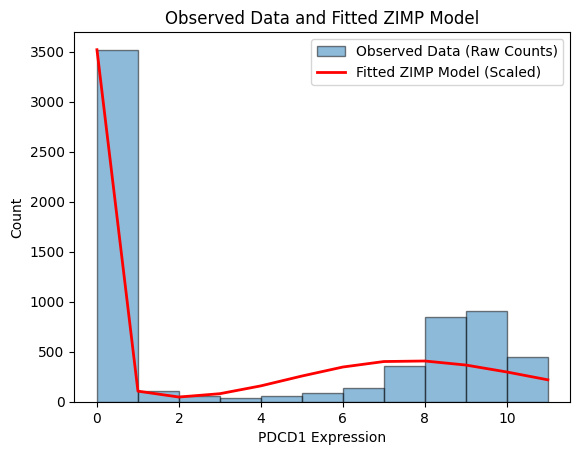

In [11]:
# Observed data
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten().astype(int)

# Define the ZIMP log-likelihood function with debugging
def zimp_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    lambdas = params[M+1:]

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(lambdas <= 0):
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * np.exp(-np.array(lambdas))
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * poisson.pmf(x, np.array(lambdas))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Poisson components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_lambdas = [2, 8]  # Observed peaks in the histogram

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_lambdas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M  # Bounds for pi_0, pi_m, and lambda_m

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimp_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
lambdas_est = result.x[M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Poisson Means (lambda_m): {lambdas_est}")

# Generate the ZIMP curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimp_pmf(x, pi_zero, mix_proportions, lambdas):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * np.exp(-np.array(lambdas))
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * poisson.pmf(x, np.array(lambdas))
        )

zimp_probs = [zimp_pmf(x, pi_zero_est, mix_proportions_est, lambdas_est) for x in x_values]

# Scale ZIMP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimp_probs_scaled = np.array(zimp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimp_probs_scaled, 'r-', label="Fitted ZIMP Model (Scaled)", linewidth=2)
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMP Model")
plt.legend()
plt.show()


#### Three Poisson Components

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            7     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.18546D+04    |proj g|=  2.48090D+01

At iterate    1    f=  1.16684D+04    |proj g|=  2.18002D+01

At iterate    2    f=  1.14597D+04    |proj g|=  8.85528D+00

At iterate    3    f=  1.14492D+04    |proj g|=  9.60819D+00

At iterate    4    f=  1.14247D+04    |proj g|=  9.26940D+00

At iterate    5    f=  1.14228D+04    |proj g|=  9.25209D+00

At iterate    6    f=  1.14039D+04    |proj g|=  9.23180D+00

At iterate    7    f=  1.13791D+04    |proj g|=  8.27617D+00

At iterate    8    f=  1.13597D+04    |proj g|=  8.21526D+00

At iterate    9    f=  1.13479D+04    |proj g|=  1.56228D+00

At iterate   10    f=  1.13475D+04    |proj g|=  1.12874D+01

At iterate   11    f=  1.13473D+04    |proj g|=  1.32759D+01

At iterate   12    f=  1.13467D+04    |proj g|=  1.39651D+01

At iterate   13    f=  1.1

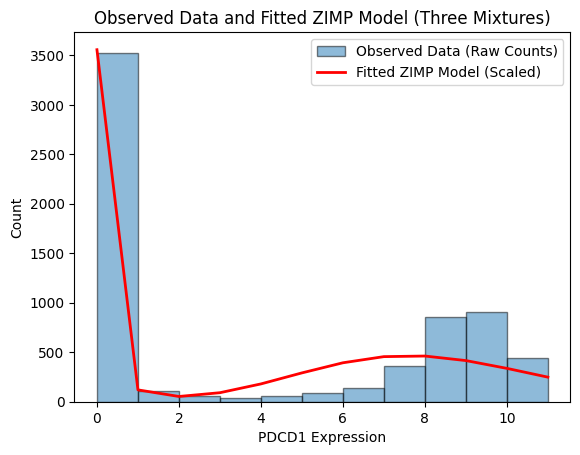

In [12]:
# Observed data
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten().astype(int)

# Define the ZIMP log-likelihood function with debugging and regularization
def zimp_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    lambdas = params[M+1:]

    # Normalize proportions
    mix_proportions /= mix_proportions.sum()

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(lambdas <= 0):
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * np.exp(-np.array(lambdas))
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * poisson.pmf(x, np.array(lambdas))
            )
        # Regularize probabilities to avoid log(0)
        prob = max(prob, 1e-10)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Initial guesses for parameters
M = 3  # Number of Poisson components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.1, 0.05, 0.85]  # Adjusted proportions
initial_lambdas = [2, 6, 10]  # Observed peaks in the histogram

# Update the initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_lambdas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M  # Bounds for pi_0, pi_m, and lambda_m

# Optimize with updated initial guesses using L-BFGS-B
result = minimize(
    zimp_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    method='L-BFGS-B',  # Use L-BFGS-B optimization method
    options={'disp': True, 'maxiter': 1000}  # Set max iterations and enable debugging output
)


# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
lambdas_est = result.x[M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Poisson Means (lambda_m): {lambdas_est}")

# Generate the ZIMP curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimp_pmf(x, pi_zero, mix_proportions, lambdas):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * np.exp(-np.array(lambdas))
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * poisson.pmf(x, np.array(lambdas))
        )

zimp_probs = [zimp_pmf(x, pi_zero_est, mix_proportions_est, lambdas_est) for x in x_values]

# Scale ZIMP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimp_probs_scaled = np.array(zimp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimp_probs_scaled, 'r-', label="Fitted ZIMP Model (Scaled)", linewidth=2)
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMP Model (Three Mixtures)")
plt.legend()
plt.show()

## Zero-Inflated Negative Binomial Mixture Model

#### Two mixtures

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11489.883337572002
            Iterations: 29
            Function evaluations: 228
            Gradient evaluations: 29
Final Log-Likelihood: -11489.883337572002
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.5364206893511827
Mixture Proportions (pi_m): [1.00000000e+00 3.80403942e-11]
Negative Binomial Means (mu): [ 7.83592126 14.10368958]
Dispersion Parameter (r): 1742.9764292962805


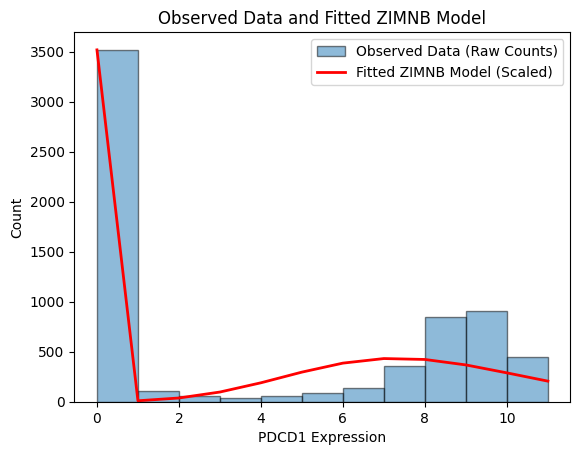

In [15]:
# Observed data for PDCD1
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model (Two Mixtures)")
plt.legend()
plt.show()

##### TCF7

Optimization terminated successfully    (Exit mode 0)
            Current function value: 7839.091021129285
            Iterations: 23
            Function evaluations: 190
            Gradient evaluations: 23
Final Log-Likelihood: -7839.091021129285
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.7213758963372856
Mixture Proportions (pi_m): [0.01511687 0.98488313]
Negative Binomial Means (mu): [5.8659837 5.835171 ]
Dispersion Parameter (r): 899.7164129865758


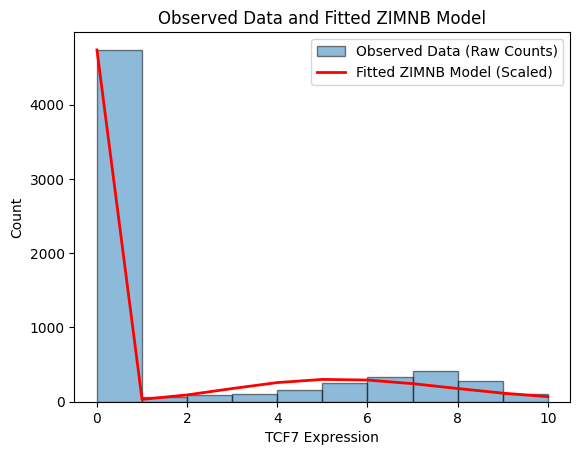

In [40]:
# Observed data for TCF7
raw_counts = cd8_adata[:, 'TCF7'].X.flatten().astype(int)

# Define the ZIMNB log-likelihood function
def zimnb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 2  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.6, 0.4]  # Adjusted proportions
initial_mus = [2, 10]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zimnb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZIMNB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zimnb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zimnb_probs = [zimnb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZIMNB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zimnb_probs_scaled = np.array(zimnb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIMNB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zimnb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("TCF7 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model")
plt.legend()
plt.show()

#### Three Mixtures

Optimization terminated successfully    (Exit mode 0)
            Current function value: 11495.029958414027
            Iterations: 35
            Function evaluations: 357
            Gradient evaluations: 35
Final Log-Likelihood: -11495.029958414027
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi_0): 0.5366144211101641
Mixture Proportions (pi_m): [1.32751693e-15 8.15673343e-01 1.84326657e-01]
Negative Binomial Means (mu): [9.16663628 7.83468967 7.83388024]
Dispersion Parameter (r): 637.3146850150358


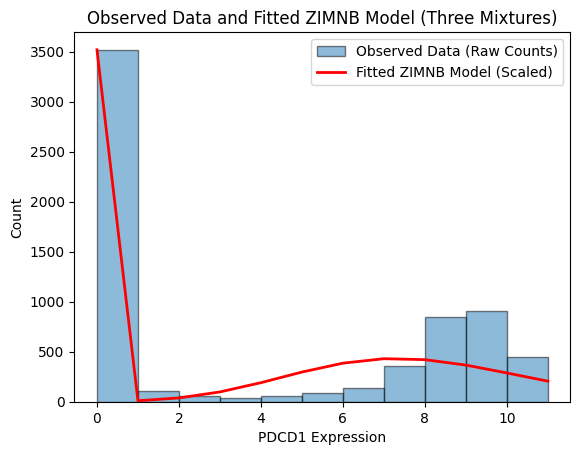

In [16]:
# Observed data
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten().astype(int)

# Define the ZINB log-likelihood function
def zinb_log_likelihood(params, data, M):
    pi_zero = params[0]
    mix_proportions = np.array(params[1:M+1])
    mus = params[M+1:2*M+1]
    r = params[-1]  # Dispersion parameter (shared across components)

    # Ensure constraints are satisfied
    if not (0 <= pi_zero <= 1):
        return -np.inf
    if np.any(mix_proportions < 0):
        return -np.inf
    if np.any(mus <= 0):
        return -np.inf
    if r <= 0:
        return -np.inf

    log_likelihood = 0
    for x in data:
        if x == 0:
            prob = pi_zero + (1 - pi_zero) * np.sum(
                mix_proportions * (r / (r + mus)) ** r
            )
        else:
            prob = (1 - pi_zero) * np.sum(
                mix_proportions * nbinom.pmf(x, r, r / (r + mus))
            )
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Return negative log-likelihood for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params):
    mix_proportions = params[1:M+1]
    return np.sum(mix_proportions) - 1

# Initial guesses for parameters
M = 3  # Number of Negative Binomial components
initial_pi_zero = (raw_counts == 0).mean()  # Proportion of zeros
initial_mix_proportions = [0.5, 0.3, 0.2]  # Adjusted proportions
initial_mus = [2, 6, 12]  # Observed peaks in the histogram
initial_r = 10  # Initial dispersion parameter

# Combine initial parameters
initial_params = [initial_pi_zero] + initial_mix_proportions + initial_mus + [initial_r]

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(1e-5, None)]  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': proportions_constraint}]

# Optimize with constraints
result = minimize(
    zinb_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_zero_est = result.x[0]
mix_proportions_est = result.x[1:M+1]
mus_est = result.x[M+1:2*M+1]
r_est = result.x[-1]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi_0): {pi_zero_est}")
print(f"Mixture Proportions (pi_m): {mix_proportions_est}")
print(f"Negative Binomial Means (mu): {mus_est}")
print(f"Dispersion Parameter (r): {r_est}")

# Generate the ZINB PMF curve
x_values = np.arange(0, raw_counts.max() + 1)

def zinb_pmf(x, pi_zero, mix_proportions, mus, r):
    if x == 0:
        return pi_zero + (1 - pi_zero) * np.sum(
            mix_proportions * (r / (r + mus)) ** r
        )
    else:
        return (1 - pi_zero) * np.sum(
            mix_proportions * nbinom.pmf(x, r, r / (r + mus))
        )

zinb_probs = [zinb_pmf(x, pi_zero_est, mix_proportions_est, mus_est, r_est) for x in x_values]

# Scale ZINB probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zinb_probs_scaled = np.array(zinb_probs) * raw_counts.size * bin_width

# Plot the histogram and ZINB model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zinb_probs_scaled, 'r-', label="Fitted ZIMNB Model (Scaled)", linewidth=2)
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIMNB Model (Three Mixtures)")
plt.legend()
plt.show()

## Zero Inflated Generalized Poisson

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            3     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.49801D+04    |proj g|=  2.36215D+03

At iterate    1    f=  1.31366D+04    |proj g|=  1.38033D+03

At iterate    2    f=  1.18217D+04    |proj g|=  4.72308D+02

At iterate    3    f=  1.15068D+04    |proj g|=  1.16016D+02

At iterate    4    f=  1.13728D+04    |proj g|=  8.69351D+00

At iterate    5    f=  1.12339D+04    |proj g|=  1.03566D+01

At iterate    6    f=  1.12237D+04    |proj g|=  1.06246D+01

At iterate    7    f=  1.12020D+04    |proj g|=  3.52375D+00

At iterate    8    f=  1.12017D+04    |proj g|=  2.35959D+00

At iterate    9    f=  1.12017D+04    |proj g|=  6.33008D-01

At iterate   10    f=  1.12017D+04    |proj g|=  5.17897D-01

At iterate   11    f=  1.12017D+04    |proj g|=  1.12123D+00
Final Log-Likelihood: -11201.688397695822
At iterate   12    f=  1.12017D+04    |proj g|=

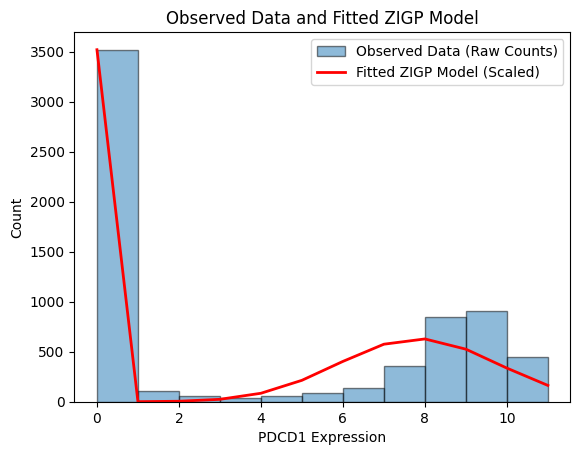

In [14]:
# Observed data
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson PMF
def zigp_pmf(x, pi, lambd, theta):
    if x == 0:
        return pi + (1 - pi) * generalized_poisson_pmf(0, lambd, theta)
    else:
        return (1 - pi) * generalized_poisson_pmf(x, lambd, theta)

# Log-likelihood function for ZIGP
def zigp_log_likelihood(params, data):
    pi, lambd, theta = params
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or lambd <= 0 or not (-1 < theta < 1):
        return np.inf  # Penalize invalid parameters
    log_likelihood = 0
    for x in data:
        prob = zigp_pmf(x, pi, lambd, theta)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Initial parameter guesses
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_lambd = raw_counts.mean()  # Mean of data
initial_theta = 0.1  # Small dispersion value
initial_params = [initial_pi, initial_lambd, initial_theta]

# Bounds for the parameters
bounds = [(0, 1), (1e-5, None), (-0.99, 0.99)]

# Optimize the log-likelihood
result = minimize(
    zigp_log_likelihood,
    initial_params,
    args=(raw_counts,),
    bounds=bounds,
    method='L-BFGS-B',
    options={'disp': True}
)

# Extract optimized parameters
pi_est, lambd_est, theta_est = result.x

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Generalized Poisson Rate (lambda): {lambd_est}")
print(f"Dispersion Parameter (theta): {theta_est}")

# Generate the ZIGP PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_pmf(x, pi_est, lambd_est, theta_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Model (Scaled)", linewidth=2)
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Model")
plt.legend()
plt.show()

## Zero Inflated Generalized Poisson Mixture Model

Optimization terminated successfully    (Exit mode 0)
            Current function value: 10891.215314244424
            Iterations: 33
            Function evaluations: 300
            Gradient evaluations: 33
Final Log-Likelihood: -10891.215314244424
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.47542440436470834
Mixture Proportions (weights): [0.05754958 0.94245042]
Generalized Poisson Rates (lambdas): [ 2.53855002 16.49846884]
Dispersion Parameters (thetas): [ 0.01222583 -0.99      ]


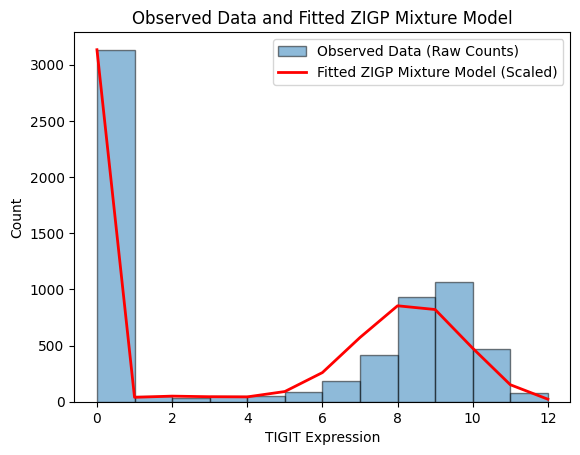

In [44]:
# Observed data
raw_counts = cd8_adata[:, 'PDCD1'].X.flatten().astype(int)

# Generalized Poisson PMF
def generalized_poisson_pmf(x, lambd, theta):
    if x < 0:
        return 0
    term1 = lambd * (lambd + theta * x) ** (x - 1)
    term2 = np.exp(-(lambd + theta * x))
    term3 = factorial(x)
    return term1 * term2 / term3

# Zero-Inflated Generalized Poisson Mixture PMF
def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
    M = len(weights)
    if x == 0:
        return pi + (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
        )
    else:
        return (1 - pi) * np.sum(
            weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
        )

# Log-likelihood function for ZIGPM
def zigp_mixture_log_likelihood(params, data, M):
    pi = params[0]
    weights = np.array(params[1:M+1])
    lambdas = params[M+1:2*M+1]
    thetas = params[2*M+1:]
    
    # Normalize weights to ensure they sum to 1
    weights /= np.sum(weights)
    
    # Ensure constraints are satisfied
    if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
        return np.inf  # Penalize invalid parameters
    
    log_likelihood = 0
    for x in data:
        prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
        prob = max(prob, 1e-10)  # Avoid log(0)
        log_likelihood += np.log(prob)
    return -log_likelihood  # Negative for minimization

# Define the constraint for mixture proportions
def proportions_constraint(params, M):
    weights = params[1:M+1]
    return np.sum(weights) - 1

# Initial guesses for parameters
M = 2  # Number of Generalized Poisson components
initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
initial_weights = [0.5, 0.5]  # Equal proportions initially
initial_lambdas = [2, 8]  # Observed peaks in the histogram
initial_thetas = [0.1, -0.1]  # Small dispersion values
initial_params = [initial_pi] + initial_weights + initial_lambdas + initial_thetas

# Define bounds
bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

# Add the constraint for mixture proportions
constraints = [{'type': 'eq', 'fun': lambda params: proportions_constraint(params, M)}]

# Optimize with constraints
result = minimize(
    zigp_mixture_log_likelihood,
    initial_params,
    args=(raw_counts, M),
    bounds=bounds,
    constraints=constraints,
    method='SLSQP',  # Use SLSQP optimization method
    options={'disp': True}  # Enable debugging output
)

# Extract optimized parameters
pi_est = result.x[0]
weights_est = result.x[1:M+1]
lambdas_est = result.x[M+1:2*M+1]
thetas_est = result.x[2*M+1:]

# Debugging log-likelihood
print(f"Final Log-Likelihood: {-result.fun}")
print("Optimization Success:", result.success)
print("Optimization Message:", result.message)
print("Estimated Parameters:")
print(f"Zero Inflation (pi): {pi_est}")
print(f"Mixture Proportions (weights): {weights_est}")
print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
print(f"Dispersion Parameters (thetas): {thetas_est}")

# Generate the ZIGPM PMF curve
x_values = np.arange(0, raw_counts.max() + 1)
zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

# Scale ZIGP probabilities to match histogram
bin_width = 1  # Bin width for histogram
bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

# Plot the histogram and ZIGP model
plt.hist(raw_counts, bins=bins, alpha=0.5, label="Observed Data (Raw Counts)", edgecolor="black")
plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
plt.xlabel("PDCD1 Expression")
plt.ylabel("Count")
plt.title("Observed Data and Fitted ZIGP Mixture Model")
plt.legend()
plt.show()


# Best: Zero-Inflated Generalized Poisson Mixture Model (ZIGPM)

In [17]:
def fit_zigp_mixture_model(cd8_adata, gene, M=2, initial_weights=None, initial_lambdas=None, initial_thetas=None):
    """
    Fits a Zero-Inflated Generalized Poisson Mixture Model to the expression data of a specified gene.

    Parameters:
    - cd8_adata: AnnData object containing gene expression data.
    - gene: The name of the gene to fit the model for.
    - M: Number of mixture components (default: 2).
    - initial_weights: Initial guesses for the mixture weights (default: equal proportions).
    - initial_lambdas: Initial guesses for the Generalized Poisson lambda values (default: [2, 8]).
    - initial_thetas: Initial guesses for the Generalized Poisson theta values (default: [0.1, -0.1]).

    Returns:
    - Optimized parameters and a plot showing the fitted model and observed data.
    """
    # Observed data for the specified gene
    raw_counts = cd8_adata[:, gene].X.flatten().astype(int)
    
    # Default initial values
    if initial_weights is None:
        initial_weights = [1/M] * M  # Equal proportions
    if initial_lambdas is None:
        initial_lambdas = np.linspace(2, 8, M)  # Spread observed peaks
    if initial_thetas is None:
        initial_thetas = np.linspace(0.1, -0.1, M)  # Small dispersion values

    # Generalized Poisson PMF
    def generalized_poisson_pmf(x, lambd, theta):
        if x < 0:
            return 0
        term1 = lambd * (lambd + theta * x) ** (x - 1)
        term2 = np.exp(-(lambd + theta * x))
        term3 = factorial(x)
        return term1 * term2 / term3

    # Zero-Inflated Generalized Poisson Mixture PMF
    def zigp_mixture_pmf(x, pi, weights, lambdas, thetas):
        if x == 0:
            return pi + (1 - pi) * np.sum(
                weights * np.array([generalized_poisson_pmf(0, lambdas[i], thetas[i]) for i in range(M)])
            )
        else:
            return (1 - pi) * np.sum(
                weights * np.array([generalized_poisson_pmf(x, lambdas[i], thetas[i]) for i in range(M)])
            )

    # Log-likelihood function for ZIGPM
    def zigp_mixture_log_likelihood(params, data):
        pi = params[0]
        weights = np.array(params[1:M+1])
        lambdas = params[M+1:2*M+1]
        thetas = params[2*M+1:]
        
        # Normalize weights to ensure they sum to 1
        weights /= np.sum(weights)
        
        # Ensure constraints are satisfied
        if not (0 <= pi <= 1) or np.any(weights < 0) or np.any(lambdas <= 0) or np.any(np.abs(thetas) >= 1):
            return np.inf  # Penalize invalid parameters
        
        log_likelihood = 0
        for x in data:
            prob = zigp_mixture_pmf(x, pi, weights, lambdas, thetas)
            prob = max(prob, 1e-10)  # Avoid log(0)
            log_likelihood += np.log(prob)
        return -log_likelihood  # Negative for minimization

    # Define the constraint for mixture proportions
    def proportions_constraint(params):
        weights = params[1:M+1]
        return np.sum(weights) - 1

    # Combine initial parameters
    initial_pi = (raw_counts == 0).mean()  # Proportion of zeros
    initial_params = [initial_pi] + initial_weights + initial_lambdas.tolist() + initial_thetas.tolist()

    # Define bounds
    bounds = [(0, 1)] + [(0, 1)] * M + [(1e-5, None)] * M + [(-0.99, 0.99)] * M  # Bounds for all parameters

    # Add the constraint for mixture proportions
    constraints = [{'type': 'eq', 'fun': proportions_constraint}]

    # Optimize with constraints
    result = minimize(
        zigp_mixture_log_likelihood,
        initial_params,
        args=(raw_counts,),
        bounds=bounds,
        constraints=constraints,
        method='SLSQP',  # Use SLSQP optimization method
        options={'disp': True}  # Enable debugging output
    )

    # Extract optimized parameters
    pi_est = result.x[0]
    weights_est = result.x[1:M+1]
    lambdas_est = result.x[M+1:2*M+1]
    thetas_est = result.x[2*M+1:]

    # Debugging log-likelihood
    print(f"Final Log-Likelihood: {-result.fun}")
    print("Optimization Success:", result.success)
    print("Optimization Message:", result.message)
    print("Estimated Parameters:")
    print(f"Zero Inflation (pi): {pi_est}")
    print(f"Mixture Proportions (weights): {weights_est}")
    print(f"Generalized Poisson Rates (lambdas): {lambdas_est}")
    print(f"Dispersion Parameters (thetas): {thetas_est}")

    # Generate the ZIGPM PMF curve
    x_values = np.arange(0, raw_counts.max() + 1)
    zigp_probs = [zigp_mixture_pmf(x, pi_est, weights_est, lambdas_est, thetas_est) for x in x_values]

    # Scale ZIGP probabilities to match histogram
    bin_width = 1  # Bin width for histogram
    bins = np.arange(raw_counts.min(), raw_counts.max() + bin_width, bin_width)
    hist_counts, bin_edges = np.histogram(raw_counts, bins=bins)
    zigp_probs_scaled = np.array(zigp_probs) * raw_counts.size * bin_width

    # Plot the histogram and ZIGP model
    plt.hist(raw_counts, bins=bins, alpha=0.5, label=f"Observed Data ({gene} Raw Counts)", edgecolor="black")
    plt.plot(x_values, zigp_probs_scaled, 'r-', label="Fitted ZIGP Mixture Model (Scaled)", linewidth=2)
    plt.xlabel(f"{gene} Expression")
    plt.ylabel("Count")
    plt.title(f"Observed Data and Fitted ZIGP Mixture Model for {gene}")
    plt.legend()
    plt.show()

    # Return the results
    return {
        "pi": pi_est,
        "weights": weights_est,
        "lambdas": lambdas_est,
        "thetas": thetas_est,
        "log_likelihood": -result.fun
    }

Fitting ZIGPM for terminal exhaustion genes...

Processing gene: PDCD1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10297.244725481294
            Iterations: 26
            Function evaluations: 233
            Gradient evaluations: 26
Final Log-Likelihood: -10297.244725481294
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5209410626492088
Mixture Proportions (weights): [0.11212719 0.88787281]
Generalized Poisson Rates (lambdas): [ 1.21798227 16.43120181]
Dispersion Parameters (thetas): [ 0.26096788 -0.99      ]


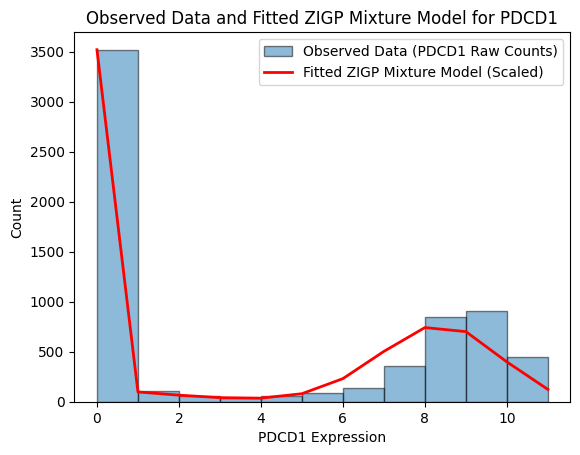


Processing gene: TOX
Optimization terminated successfully    (Exit mode 0)
            Current function value: 10560.91745697566
            Iterations: 26
            Function evaluations: 239
            Gradient evaluations: 26
Final Log-Likelihood: -10560.91745697566
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5493989790246065
Mixture Proportions (weights): [0.34705705 0.65294295]
Generalized Poisson Rates (lambdas): [ 2.8969597  13.11703192]
Dispersion Parameters (thetas): [-7.72262009e-04 -9.90000000e-01]


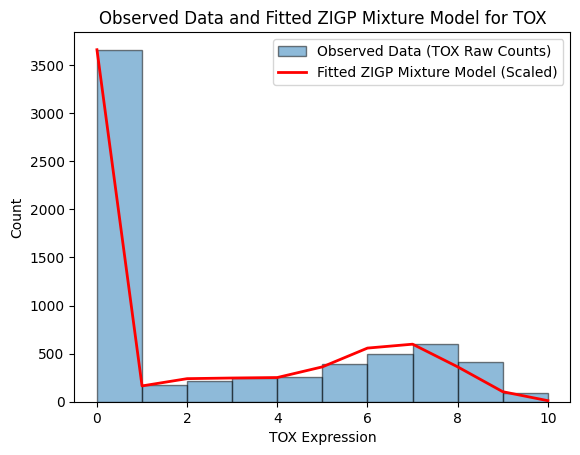


Processing gene: HAVCR2
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9947.057895230766
            Iterations: 27
            Function evaluations: 235
            Gradient evaluations: 26
Final Log-Likelihood: -9947.057895230766
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5779672496233507
Mixture Proportions (weights): [0.11263033 0.88736967]
Generalized Poisson Rates (lambdas): [ 2.78336242 16.81828558]
Dispersion Parameters (thetas): [-0.05373509 -0.99      ]


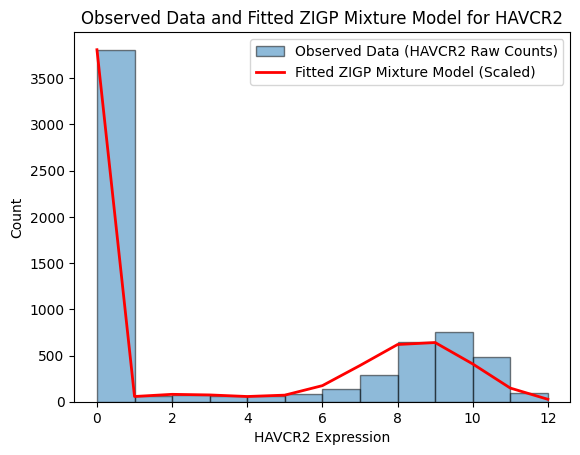


Processing gene: CD38
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9177.212769277563
            Iterations: 23
            Function evaluations: 209
            Gradient evaluations: 23
Final Log-Likelihood: -9177.212769277563
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.6303110766157548
Mixture Proportions (weights): [0.15874996 0.84125004]
Generalized Poisson Rates (lambdas): [ 2.48909343 15.79777609]
Dispersion Parameters (thetas): [-0.0156031 -0.99     ]


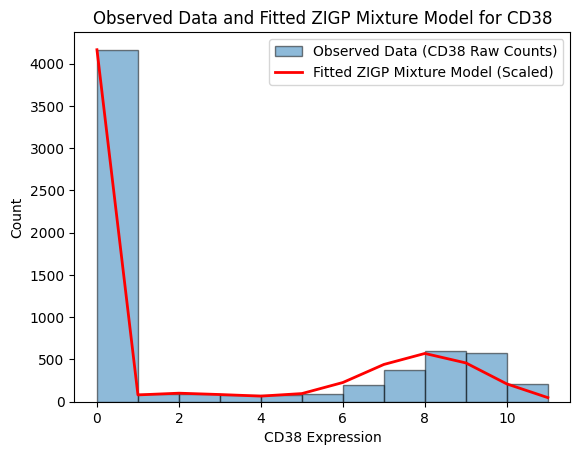


Processing gene: LAG3
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9588.666958049213
            Iterations: 24
            Function evaluations: 220
            Gradient evaluations: 24
Final Log-Likelihood: -9588.666958049213
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.5959371180771903
Mixture Proportions (weights): [0.18213347 0.81786653]
Generalized Poisson Rates (lambdas): [ 2.11114326 13.89723587]
Dispersion Parameters (thetas): [ 0.1090969 -0.99     ]


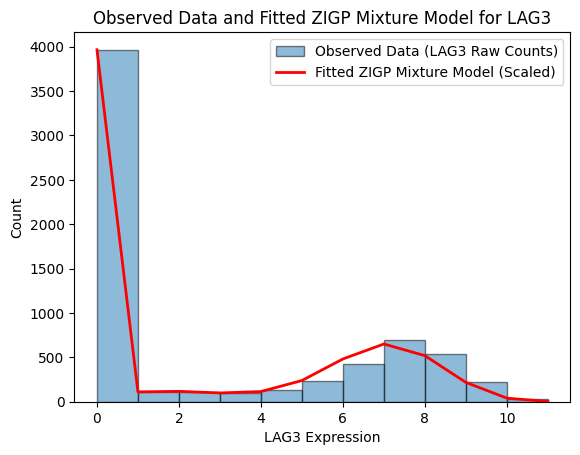


Processing gene: ENTPD1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7705.750141121902
            Iterations: 22
            Function evaluations: 209
            Gradient evaluations: 22
Final Log-Likelihood: -7705.750141121902
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7201578464585666
Mixture Proportions (weights): [0.23242042 0.76757958]
Generalized Poisson Rates (lambdas): [ 3.28224983 15.16503823]
Dispersion Parameters (thetas): [ 0.03996218 -0.99      ]


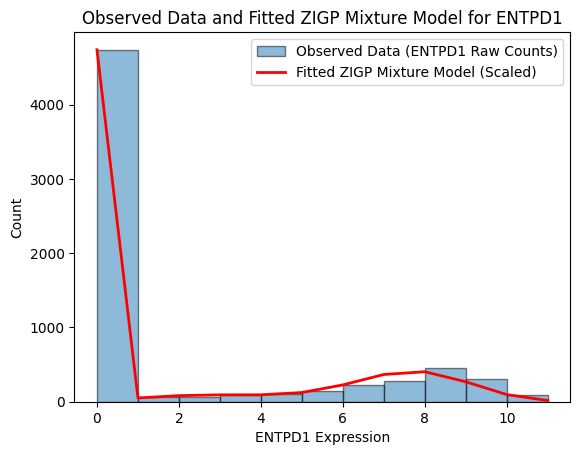


Processing gene: BATF
Optimization terminated successfully    (Exit mode 0)
            Current function value: 8161.563036735259
            Iterations: 24
            Function evaluations: 222
            Gradient evaluations: 24
Final Log-Likelihood: -8161.563036735259
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.6886208178784176
Mixture Proportions (weights): [0.17499927 0.82500073]
Generalized Poisson Rates (lambdas): [ 2.94852206 16.01760989]
Dispersion Parameters (thetas): [-0.23450567 -0.99      ]


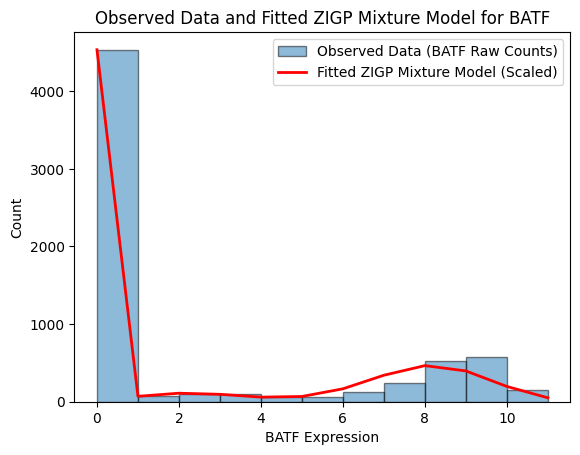


Processing gene: LGALS9
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5685.191444237375
            Iterations: 22
            Function evaluations: 203
            Gradient evaluations: 22
Final Log-Likelihood: -5685.191444237375
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.8096964871497137
Mixture Proportions (weights): [0.18127796 0.81872204]
Generalized Poisson Rates (lambdas): [ 4.08224329 14.55603675]
Dispersion Parameters (thetas): [-0.13735502 -0.99      ]


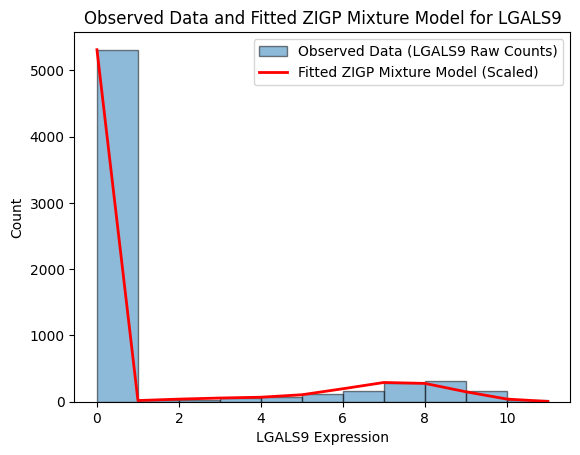


Fitting ZIGPM for progenitor exhaustion genes...

Processing gene: TCF7
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7606.798390129451
            Iterations: 23
            Function evaluations: 211
            Gradient evaluations: 23
Final Log-Likelihood: -7606.798390129451
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7197717030853227
Mixture Proportions (weights): [0.24802667 0.75197333]
Generalized Poisson Rates (lambdas): [ 3.20599388 12.61960523]
Dispersion Parameters (thetas): [ 0.00468759 -0.89759591]


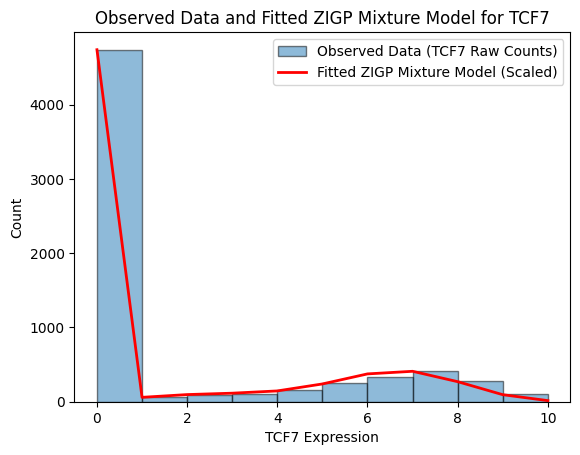


Processing gene: CXCR5
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2844.793930824026
            Iterations: 20
            Function evaluations: 181
            Gradient evaluations: 20
Final Log-Likelihood: -2844.793930824026
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.9205447519595907
Mixture Proportions (weights): [0.4045231 0.5954769]
Generalized Poisson Rates (lambdas): [ 3.15673052 11.4361447 ]
Dispersion Parameters (thetas): [-0.02803165 -0.89836272]


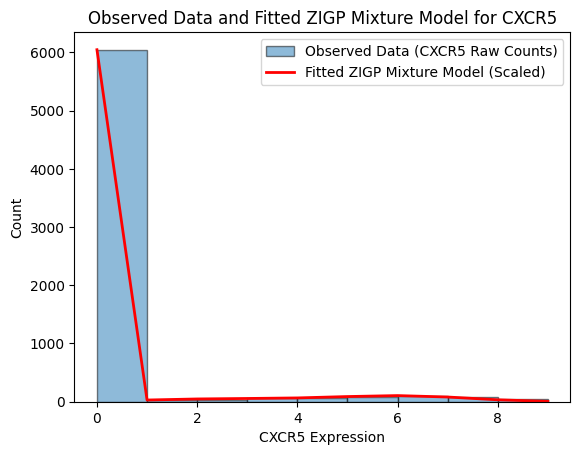


Processing gene: SLAMF6
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7522.138105288759
            Iterations: 23
            Function evaluations: 212
            Gradient evaluations: 23
Final Log-Likelihood: -7522.138105288759
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7167592423363369
Mixture Proportions (weights): [0.2350888 0.7649112]
Generalized Poisson Rates (lambdas): [ 1.79935683 14.84695594]
Dispersion Parameters (thetas): [ 0.15200354 -0.99      ]


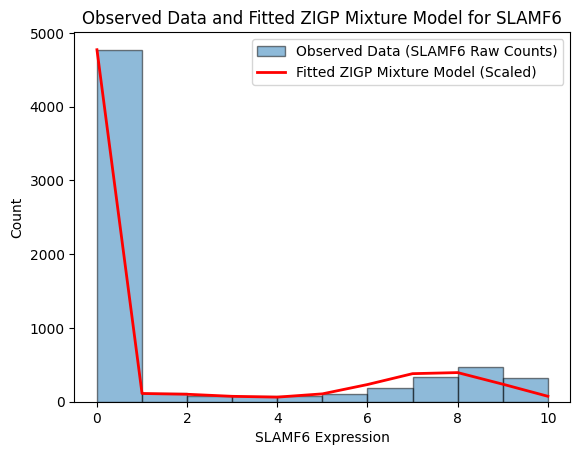


Processing gene: IL7R
Optimization terminated successfully    (Exit mode 0)
            Current function value: 7741.677942885116
            Iterations: 23
            Function evaluations: 214
            Gradient evaluations: 23
Final Log-Likelihood: -7741.677942885116
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.7157156281228538
Mixture Proportions (weights): [0.15137406 0.84862594]
Generalized Poisson Rates (lambdas): [ 3.43625587 16.70958683]
Dispersion Parameters (thetas): [ 0.09944651 -0.99      ]


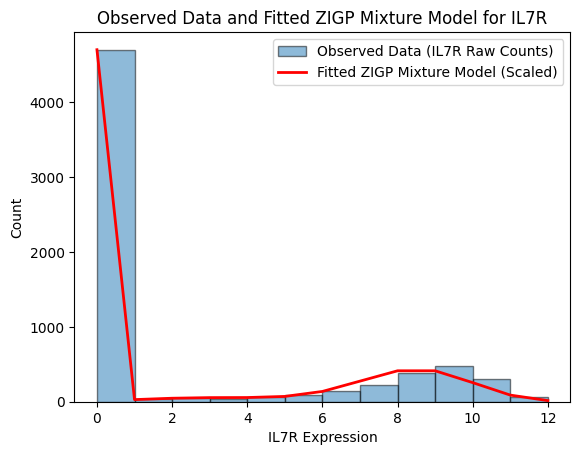


Processing gene: LEF1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 2871.9578521413655
            Iterations: 20
            Function evaluations: 175
            Gradient evaluations: 20
Final Log-Likelihood: -2871.9578521413655
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.9227443526170105
Mixture Proportions (weights): [0.28072888 0.71927112]
Generalized Poisson Rates (lambdas): [ 3.44233053 15.94666514]
Dispersion Parameters (thetas): [ 0.02084988 -0.99      ]


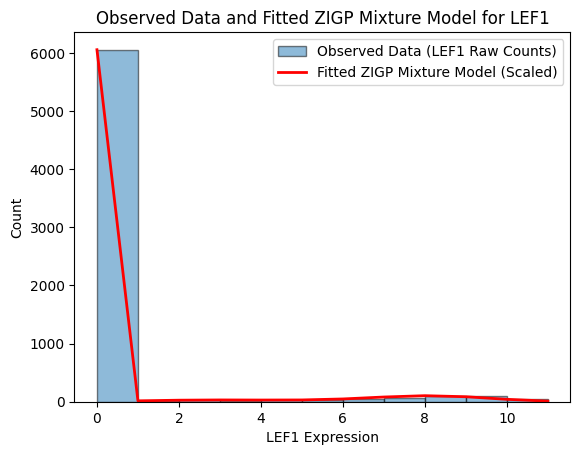


Processing gene: SELL
Optimization terminated successfully    (Exit mode 0)
            Current function value: 5272.986989355567
            Iterations: 23
            Function evaluations: 204
            Gradient evaluations: 23
Final Log-Likelihood: -5272.986989355567
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.828095408170457
Mixture Proportions (weights): [0.24049924 0.75950076]
Generalized Poisson Rates (lambdas): [ 1.86071794 16.8693925 ]
Dispersion Parameters (thetas): [ 0.11453511 -0.99      ]


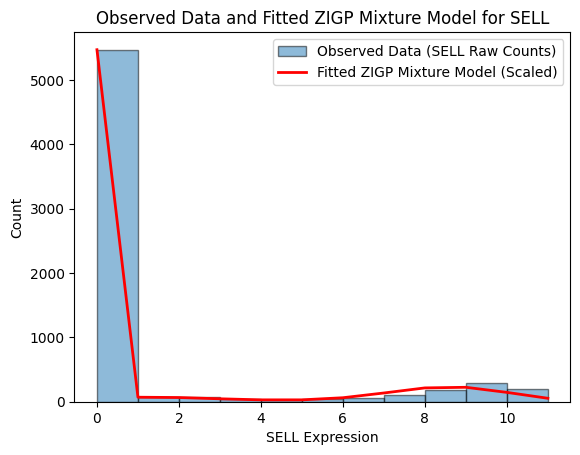


Processing gene: STAT4
Optimization terminated successfully    (Exit mode 0)
            Current function value: 12135.93739649592
            Iterations: 25
            Function evaluations: 223
            Gradient evaluations: 25
Final Log-Likelihood: -12135.93739649592
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.4288882300650296
Mixture Proportions (weights): [0.17713839 0.82286161]
Generalized Poisson Rates (lambdas): [ 4.43659403 15.61441797]
Dispersion Parameters (thetas): [-0.05150573 -0.99      ]


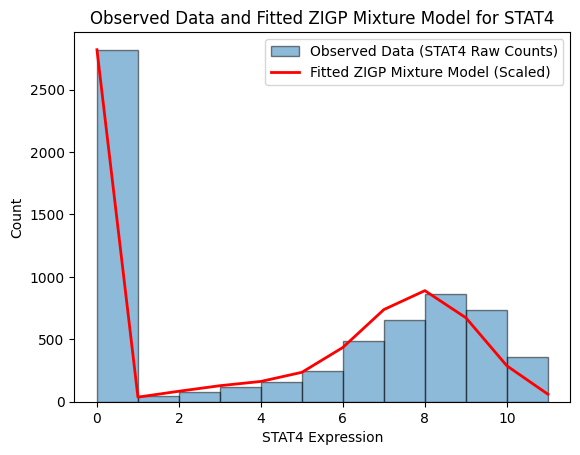


Processing gene: FOXP1
Optimization terminated successfully    (Exit mode 0)
            Current function value: 9934.862976989585
            Iterations: 19
            Function evaluations: 180
            Gradient evaluations: 19
Final Log-Likelihood: -9934.862976989585
Optimization Success: True
Optimization Message: Optimization terminated successfully
Estimated Parameters:
Zero Inflation (pi): 0.599246976104951
Mixture Proportions (weights): [0.40994467 0.59005533]
Generalized Poisson Rates (lambdas): [ 3.1814466  13.53602965]
Dispersion Parameters (thetas): [-1.40326491e-04 -9.90000000e-01]


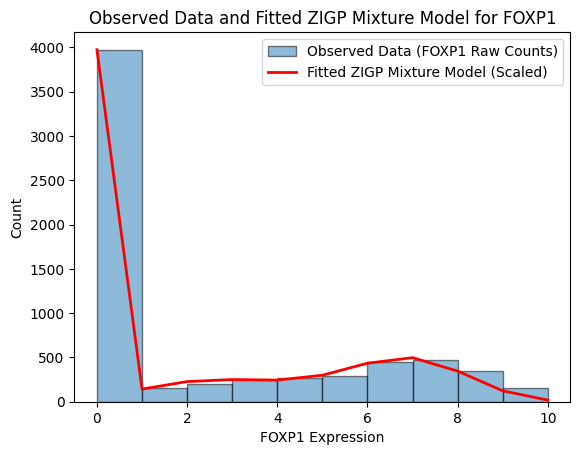


Finished processing all genes.


In [18]:
# Gene lists
progenitor_ex_genes = ["TCF7", "CXCR5", "SLAMF6", "IL7R", "LEF1", "SELL", "STAT4", "FOXP1"]
terminal_ex_genes = ["PDCD1", "TOX", "HAVCR2", "CD38", "LAG3", "ENTPD1", "BATF", "LGALS9"]

# Results storage
results = {}

# Fit the ZIGPM model for each gene in the terminal_ex_genes list
print("Fitting ZIGPM for terminal exhaustion genes...")
results["terminal_ex_genes"] = {}
for gene in terminal_ex_genes:
    print(f"\nProcessing gene: {gene}")
    try:
        results["terminal_ex_genes"][gene] = fit_zigp_mixture_model(cd8_adata, gene, M=2)
    except Exception as e:
        print(f"Failed to process {gene}: {e}")

# Fit the ZIGPM model for each gene in the progenitor_ex_genes list
print("\nFitting ZIGPM for progenitor exhaustion genes...")
results["progenitor_ex_genes"] = {}
for gene in progenitor_ex_genes:
    print(f"\nProcessing gene: {gene}")
    try:
        results["progenitor_ex_genes"][gene] = fit_zigp_mixture_model(cd8_adata, gene, M=2)
    except Exception as e:
        print(f"Failed to process {gene}: {e}")

# Display summary of results
print("\nFinished processing all genes.")


# Cell State Probability Distribution

### Beta Mixture Model

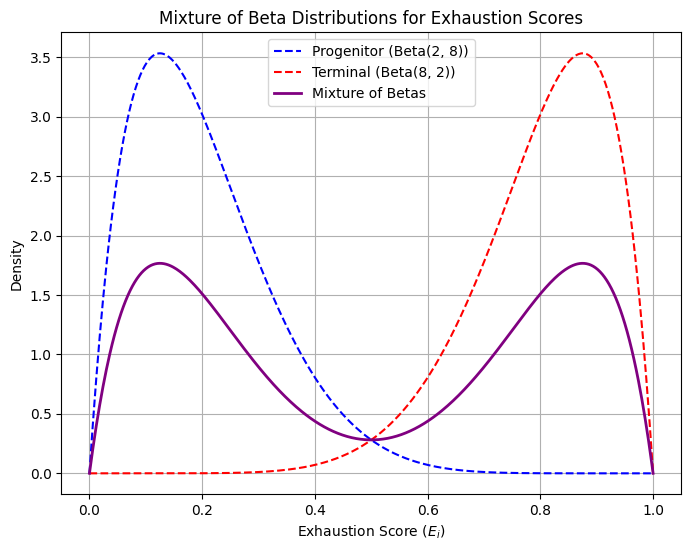

In [2]:
# Parameters for the mixture of Beta distributions
alpha_1, beta_1 = 2, 8  # Progenitor exhausted
alpha_2, beta_2 = 8, 2  # Terminally exhausted

# Mixture weight
w = 0.5  # Equal mixture weight

# Define the range for exhaustion scores
x = np.linspace(0, 1, 500)

# Compute the Beta distributions
beta_1_pdf = beta.pdf(x, alpha_1, beta_1)
beta_2_pdf = beta.pdf(x, alpha_2, beta_2)

# Compute the mixture of Betas
mixture_pdf = w * beta_1_pdf + (1 - w) * beta_2_pdf

# Plot the distributions
plt.figure(figsize=(8, 6))
plt.plot(x, beta_1_pdf, label=f"Progenitor (Beta({alpha_1}, {beta_1}))", linestyle="--", color="blue")
plt.plot(x, beta_2_pdf, label=f"Terminal (Beta({alpha_2}, {beta_2}))", linestyle="--", color="red")
plt.plot(x, mixture_pdf, label="Mixture of Betas", color="purple", linewidth=2)
plt.title("Mixture of Beta Distributions for Exhaustion Scores")
plt.xlabel("Exhaustion Score ($E_i$)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()

### Gamma Hyperpriors

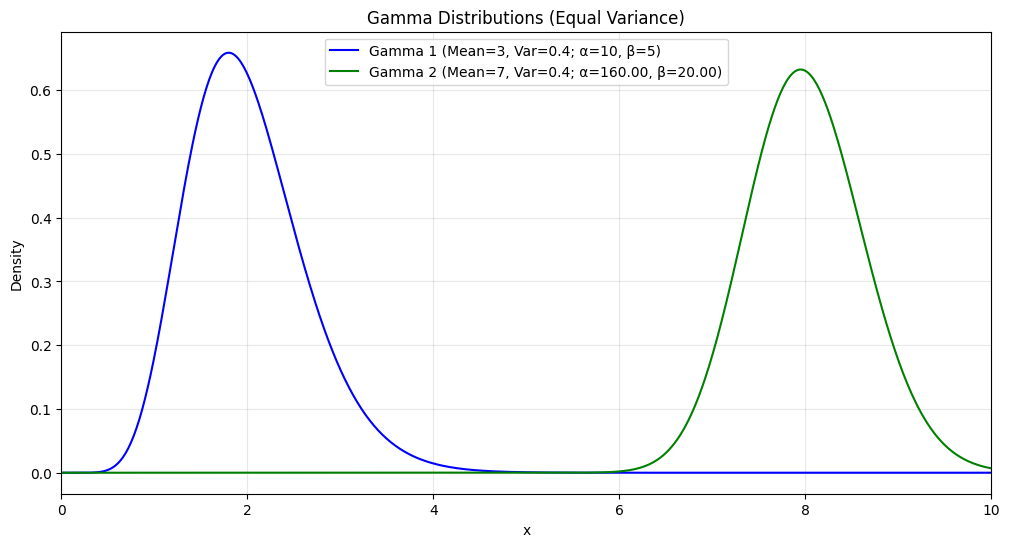

In [7]:
from scipy.stats import gamma
import numpy as np
import matplotlib.pyplot as plt

# Define Gamma parameters
alpha_1, beta_1 = 10, 5
alpha_2, beta_2 = 160, 20

# Generate x values
x = np.linspace(0, 15, 1000)

# Compute PDFs
pdf_gamma_1 = gamma.pdf(x, a=alpha_1, scale=1 / beta_1)
pdf_gamma_2 = gamma.pdf(x, a=alpha_2, scale=1 / beta_2)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(x, pdf_gamma_1, label=f"Gamma 1 (Mean=3, Var=0.4; α={alpha_1}, β={beta_1})", color="blue")
plt.plot(x, pdf_gamma_2, label=f"Gamma 2 (Mean=7, Var=0.4; α={alpha_2:.2f}, β={beta_2:.2f})", color="green")
plt.title("Gamma Distributions (Equal Variance)")
plt.xlabel("x")
plt.ylabel("Density")
plt.legend()
plt.grid(alpha=0.3)
plt.xlim(0, 10)
plt.show()
